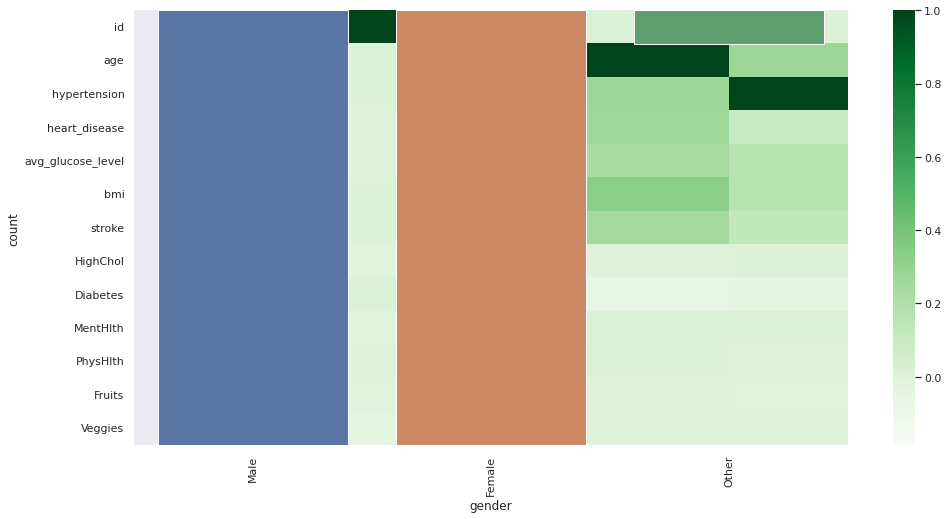

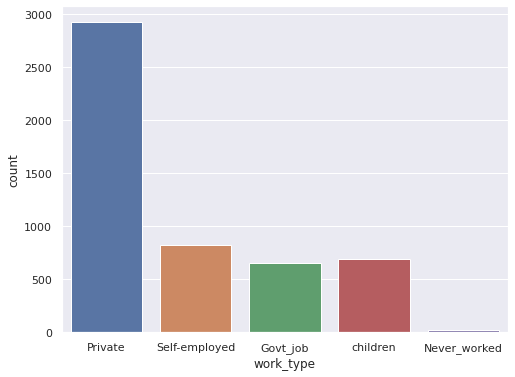

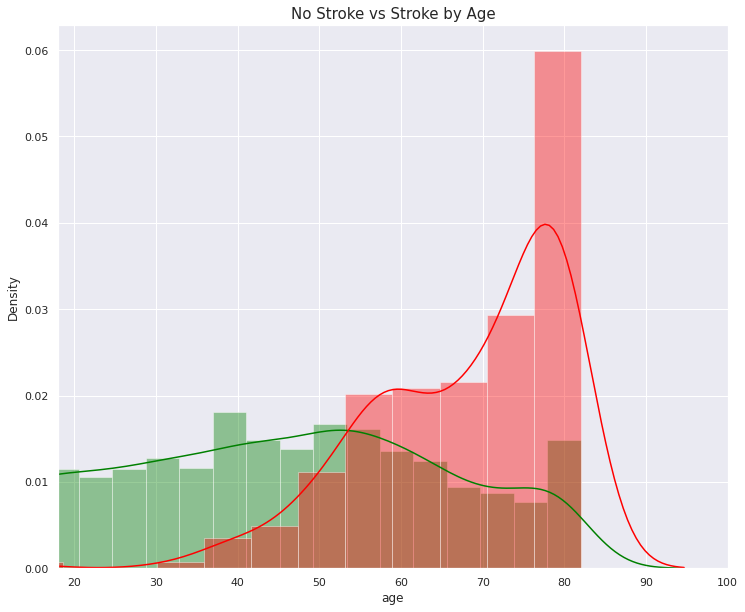

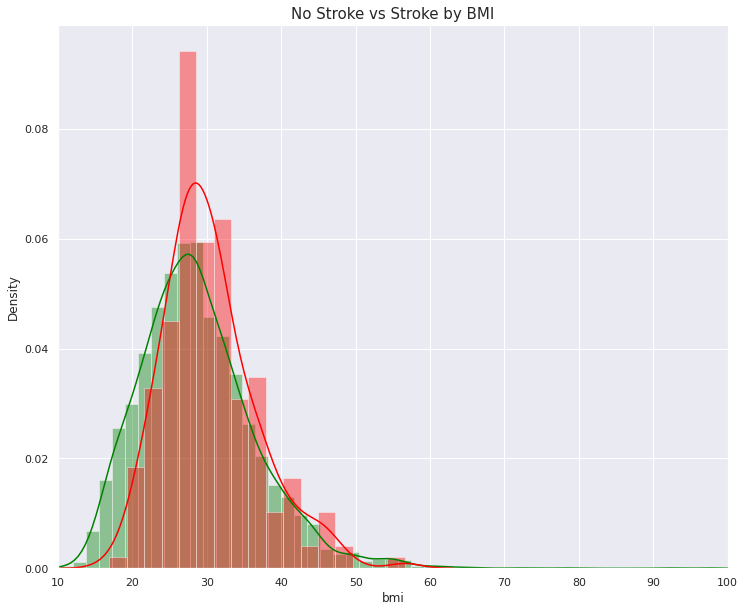

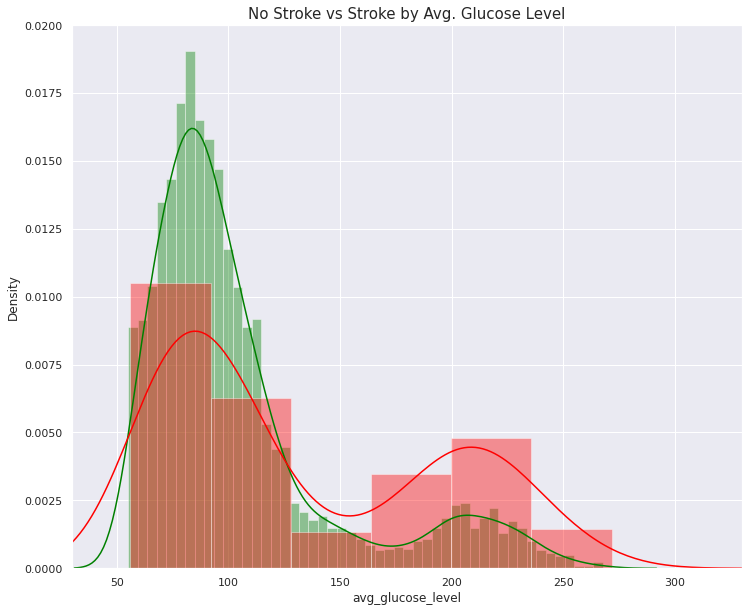

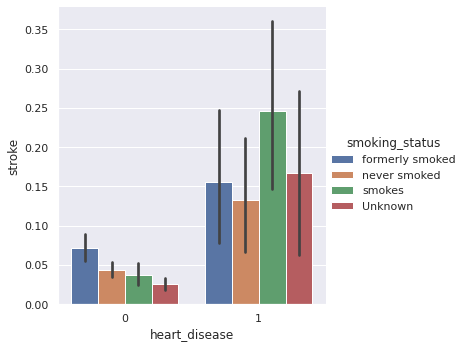

In [ ]:
# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Computational libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv("healthcare-dataset-stroke-data.csv")


data.head()

import plotly.express as ex

fig = ex.pie(data,names='stroke')
fig.update_layout(title='Proportion Of Stroke Samples')
fig.show()

sns.set_theme(style="darkgrid")

plt.figure(figsize=(16,8))
sns.heatmap(data.corr(),cmap="Greens");

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.countplot(data=data, x="gender")
plt.show()

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.countplot(data=data, x="work_type")
plt.show()

fig = ex.pie(data,names='smoking_status')
fig.update_layout(title='Proportion Of Different Smoking Categories Among Stroke Population')
fig.show()


plt.figure(figsize=(12, 10))

sns.distplot(data[data['stroke'] == 0]["age"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["age"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

plt.figure(figsize=(12,10))

sns.distplot(data[data['stroke'] == 0]["bmi"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["bmi"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by BMI', fontsize=15)
plt.xlim([10,100])
plt.show()

plt.figure(figsize=(12,10))

sns.distplot(data[data['stroke'] == 0]["avg_glucose_level"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["avg_glucose_level"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Avg. Glucose Level', fontsize=15)
plt.xlim([30,330])
plt.show()

sns.catplot(x="heart_disease", y="stroke", hue='smoking_status', kind="bar", data=data);



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

data = pd.read_csv('healthcare-dataset-stroke-data.csv', na_values='N/A')


# Removing " " empty space between feature values

from pandas.api.types import is_string_dtype

for column in data.columns:
    if (is_string_dtype(data[column].dtype)):
        data[column] = data[column].str.strip()


X = data.loc[:, data.columns != 'stroke']
y = data['stroke']


print(X.shape, y.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Train - 80% , Test - 20%


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.impute import SimpleImputer


si_X_train = pd.DataFrame() # create a new dataframe to save the train dataset
si_X_test = pd.DataFrame() # create a new dataframe to save the test dataset


for column in X_train.columns:
  if (is_string_dtype(X_train[column].dtype)):
    si = SimpleImputer(strategy='most_frequent')
  else:
    si = SimpleImputer(strategy='median')
  si.fit(X_train[[column]])
  si_X_train[column] = si.transform(X_train[[column]]).flatten() # Flatten 2D matrix to 1D
  si_X_test[column] = si.transform(X_test[[column]]).flatten()


si_X_train

categorical_features = []
for col in data.columns:
  if col=='Class':
    continue
  if is_string_dtype(data[col].dtype):
    categorical_features.append(col)


categorical_features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


# Convert the Label Class

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


l_X_train = pd.DataFrame() # Train dataset --> before scaling
l_X_test = pd.DataFrame() # Test dataset --> before scaling


# Convert the text features

for column in X_train.columns:
  if column in categorical_features:
    l_X_train[column] = le.fit_transform(si_X_train[column])
    l_X_test[column] = le.transform(si_X_test[column])
  else:
    l_X_train[column] = si_X_train[column].copy()
    l_X_test[column] = si_X_test[column].copy()


l_X_train.isnull().sum()

from imblearn.over_sampling import RandomOverSampler

os=RandomOverSampler(0.75) # 75%
l_X_train_ns,y_train_ns = os.fit_resample(l_X_train,y_train)

print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

l_X_train_ns = ss.fit_transform(l_X_train_ns)
l_X_test = ss.transform(l_X_test)


print(l_X_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def evaluate_preds(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test,y_pred)

    metric_dict = {
        "accuracy":round(accuracy,2),
        "precision":round(precision,2),
        "recall":round(recall,2),
        "f1":round(f1,2),
        "mcc": mcc
    } # A dictionary that stores the results of the evaluation metrics

    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print(f'MCC Score: {mcc:.2f}')

    return metric_dict

print()
print("SUPPORT VECTOR MACHINE")
from sklearn.svm import SVC
svc = SVC(kernel='rbf',random_state=0)
svc.fit(l_X_train_ns,y_train_ns)
y_pred = svc.predict(l_X_test)
model_metrics = evaluate_preds(y_test, y_pred)

print()
print("NAIVE BAYES")
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(l_X_train_ns,y_train_ns)
y_pred = naive.predict(l_X_test)
model_metrics = evaluate_preds(y_test, y_pred)

print()
print("LOGISTIC REGRESSION")
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(l_X_train_ns,y_train_ns)

y_pred = logistic.predict(l_X_test)
model_metrics = evaluate_preds(y_test, y_pred)

print()
print("KNN")
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(l_X_train_ns,y_train_ns)


y_pred = neigh.predict(l_X_test)
model_metrics = evaluate_preds(y_test, y_pred)

print()
print("RANDOM FOREST")
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion='entropy')
rf.fit(l_X_train_ns,y_train_ns)


y_pred = rf.predict(l_X_test)
model_metrics = evaluate_preds(y_test, y_pred)

from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV will refit the estimator, i.e. model object using the best found parameters on the whole dataset.

parameters = [ # list of different combination of hyperparameters that we want to test
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
]
# also, two dictionaries --> for testing 2 different kernels. {key - parameters(name must match documentation), value - range of values to try}

random_cv = RandomizedSearchCV(estimator = svc,
                           param_distributions = parameters,
                           scoring = 'accuracy', # evaluation metric. 'accuracy' for classification here
                           cv = 5, # k = 5, no. of k-train test folds
                           verbose=2, # print out the results
                           n_jobs = -1, # set processor of machine. -1 --> means all processor will be in  use
                           refit=True)

# RandomizedSearchCV is only applied on train set
random_cv.fit(l_X_train_ns, y_train_ns)

# get best accuracy, and the set of parameters that led to that best accuracy
best_accuracy = random_cv.best_score_
best_parameters = random_cv.best_params_
print()
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

parameters = [ # list of different combination of hyperparameters that we want to test
              {'n_estimators': range(10,300,10), 'criterion': ['gini', 'entropy'], 'max_features':['auto','sqrt','log2']}
]


random_cv = RandomizedSearchCV(estimator = rf,
                           param_distributions = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=2,
                           n_jobs = -1,
                           refit=True)


random_cv.fit(l_X_train_ns, y_train_ns)


best_accuracy = random_cv.best_score_
best_parameters = random_cv.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)



(5110, 17) (5110,)
(4088, 17) (1022, 17) (4088,) (1022,)
The number of classes before fit Counter({0: 3893, 1: 195})
The number of classes after fit Counter({0: 3893, 1: 2919})
           id  gender   age  hypertension  heart_disease  ever_married  \
0     28932.0       0  36.0           0.0            0.0             1   
1     37150.0       0  34.0           0.0            0.0             1   
2     71669.0       1  60.0           0.0            0.0             1   
3     27153.0       0  75.0           0.0            0.0             1   
4     58235.0       1  76.0           0.0            0.0             1   
...       ...     ...   ...           ...            ...           ...   
4083  30457.0       0  53.0           1.0            0.0             1   
4084  24836.0       0  61.0           0.0            0.0             1   
4085  17079.0       1  44.0           0.0            0.0             1   
4086  72340.0       1  21.0           0.0            0.0             0   
4087  522